In [1]:
import os
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision.transforms as transforms

from torchvision.io import read_image
from torch.utils.data import Dataset
from PIL import Image

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('You can learn how to use GPU if you have cuda enabled\n')

Using device: cpu
You can learn how to use GPU if you have cuda enabled



In [2]:
class HandImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.classes = sorted(self.img_labels.iloc[:, 1].unique())
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image.permute(1, 2, 0).numpy())
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert the image to a PIL Image
    transforms.Grayscale(num_output_channels=1),  # Convert the image to grayscale (1 channel)
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(20),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the data to have mean 0 and std 1
])

# Load Fashion MNIST dataset
# Thomas Path: G:/My Drive/RPI/Classes/Intro to ML/FInal Project/Fun Stuff/#rdi/
trainset = HandImageDataset(
    annotations_file='G:/My Drive/RPI/Classes/Intro to ML/FInal Project/Fun Stuff/120924_2/training.csv',
    img_dir='G:/My Drive/RPI/Classes/Intro to ML/FInal Project/Fun Stuff/120924_2/training',
    transform=transform
)

testset = HandImageDataset(
    annotations_file='G:/My Drive/RPI/Classes/Intro to ML/FInal Project/Fun Stuff/120924_2/test.csv',
    img_dir='G:/My Drive/RPI/Classes/Intro to ML/FInal Project/Fun Stuff/120924_2/test',
    transform=transform
)

sample_image, sample_label = trainset[0]

print(f'trainset.data.shape: {sample_image.numpy().shape}') #\ntestset.data.shape: {testset.data.shape}')
classes = trainset.classes
print(f'classes: {classes}')

trainset.data.shape: (1, 224, 224)
classes: [1, 2, 3, 4, 5, 6]


torch.Size([64, 1, 224, 224])


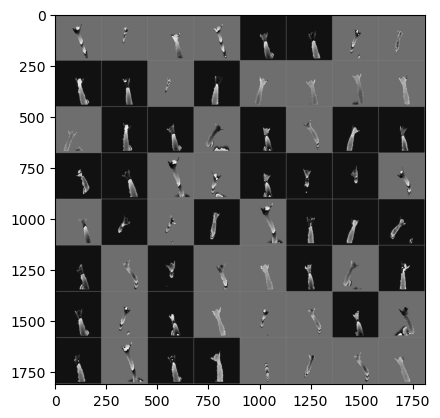

In [4]:
# Create data loaders
batch_size = 64 # modify if necessary
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter)

print(images.shape)

# # show images
imshow(torchvision.utils.make_grid(images))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.flatten = nn.Flatten()
        
        # self.network = nn.Sequential(
        self.il = nn.Linear(224*224, 1024)       # First fully connected layer
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(0.3)                  # Dropout for regularization
        
        self.hl2 = nn.Linear(1024, 512)             # Second fully connected layer
        self.bn2 = nn.BatchNorm1d(512)
        
        self.hl3 = nn.Linear(512, 256)              # Third fully connected layer
        self.bn3 = nn.BatchNorm1d(256)
        
        self.out = nn.Linear(256, 7)# Output layer
        self.softmax = nn.Softmax(dim=1) 
        # )

    def forward(self, x):
        x = self.flatten(x)
        x = self.il(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)
        
        x = self.hl2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.dropout(x)
        
        x = self.hl3(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.dropout(x)
        
        x = self.out(x)
        x = self.softmax(x)
        return x
        

#### Training. We ask you to complete this in a function for reuse

In [6]:
##################################
##  TODO: Complete this cell
##################################

import torch.optim as optim
import scipy.signal
from datetime import datetime

## load your model
model = MLP().to(device)

## parameters that can be tuned
batch_size = 24
learning_rate = 0.001
num_epochs = 3

## necessary initializations
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
criterion = nn.CrossEntropyLoss() ## TODO: define the loss function
optimizer = optim.Adam(model.parameters(), lr = learning_rate) ## TODO: define the optimizer


def train_model(model, trainloader, criterion, optimizer, num_epochs=3):
    """Train a neural network model on the given dataset.
    
    Inputs:
        model (torch.nn.Module): The neural network model to train
        trainloader (torch.utils.data.DataLoader): Training data loader
        criterion (torch.nn.Module): Loss function
        optimizer (torch.optim.Optimizer): Optimizer
        num_epochs (int, optional): Number of training epochs. Defaults to 3
    
    Outputs:
        train_losses: a list, history of losses
    """
    # Track loss history
    train_losses = []
    
    # Set model to training mode
    model.train()

    # Start timing
    start_time = datetime.now()
    last_loss = 0.0
    
    for epoch in range(num_epochs):
        ## TODO: complete the training loop
        ## you need to move data to device if you use GPU
        running_loss = 0.0
        i = 0

        for inputs, labels in trainloader:
            # Get inputs and labels, move to device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track stastics
            running_loss += loss.item()


            train_losses.append(loss.item())
            i += 1
            
        print(f'Epoch {epoch+1}, Loss: {running_loss/batch_size}')
        running_loss = 0
    
    # Print total training time
    total_time = datetime.now() - start_time
    print(f'Finished Training. Total time: {total_time}')

    train_losses = scipy.signal.savgol_filter(train_losses, 51, 5)
    return train_losses

Epoch 1, Loss: 0.056389105127891526
Epoch 2, Loss: 0.05768461248953827
Epoch 3, Loss: 0.07902295555686578
Epoch 4, Loss: 0.08748231644858606
Epoch 5, Loss: 0.049070069537265226
Epoch 6, Loss: 0.03964890135102905
Epoch 7, Loss: 0.05107841266726609
Epoch 8, Loss: 0.04407907711720327
Epoch 9, Loss: 0.057473136970656924
Epoch 10, Loss: 0.04230844831909053
Finished Training. Total time: 0:06:27.687309


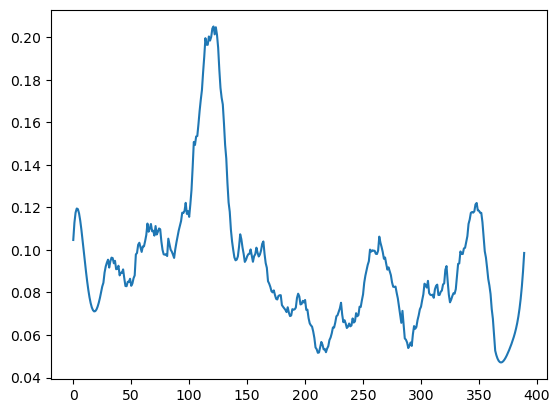

In [42]:
## train the model
mlp_losses = train_model(model, trainloader, criterion, optimizer, num_epochs=10)
plt.plot(mlp_losses)
plt.show()

In [7]:
#################################
## This is the cell for checking
## Do NOT edit this cell
#################################

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, device, name="test"):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Accuracy on {name} set: {accuracy:.4f}')
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name} set)')
    
    # Add colorbar
    plt.colorbar()
    
    # Add labels
    true_classes = ['hangloose', 'middlefinger', 'peace', 'rock', 'spiderman', 'thumbsup']
    tick_marks = np.arange(len(true_classes))
    plt.xticks(tick_marks, true_classes, rotation=45)
    plt.yticks(tick_marks, true_classes)
    
    # Add numbers to cells
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return accuracy, cm

Accuracy on train set: 0.9920


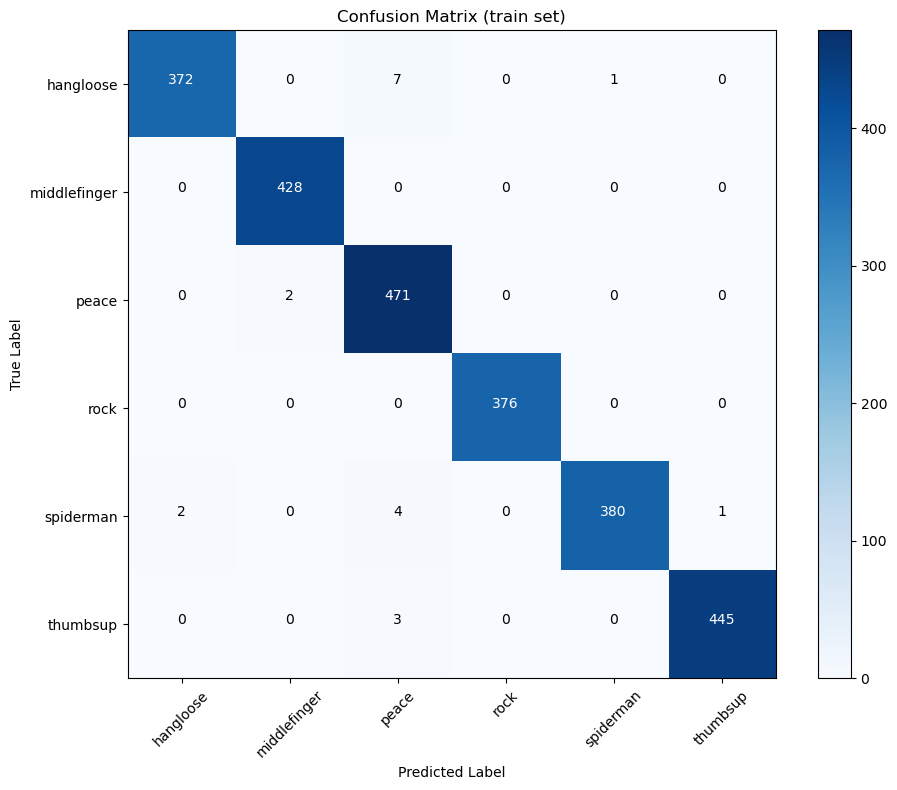

Accuracy on test set: 0.8628


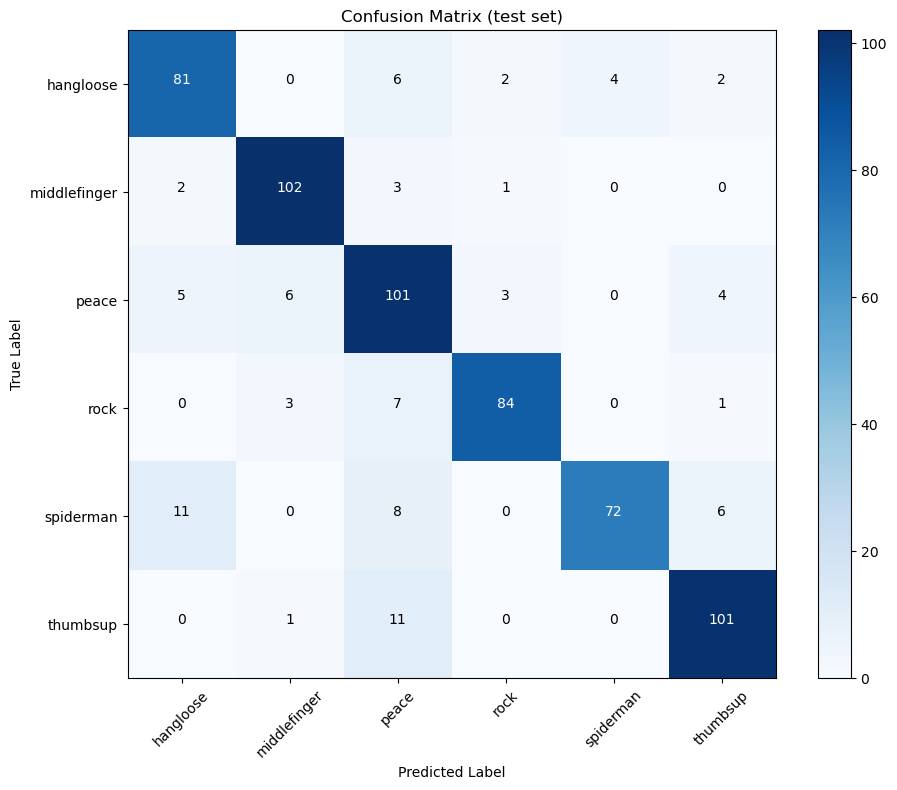

In [43]:
train_acc, train_cm = evaluate_model(model, trainloader, device, "train")
test_acc, test_cm = evaluate_model(model, testloader, device, "test")

In [11]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        
        # First convolution block
        self.cl1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=2, stride=2, padding=1)  # Output: (8, 112, 112)
        self.bn1 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (8, 56, 56)
        self.dropout1 = nn.Dropout(0.3)
        
        # Second convolution block
        self.cl2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, stride=2, padding=1)  # Output: (16, 28, 28)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (16, 14, 14)
        
        # Third convolution block
        self.cl3 = nn.Conv2d(in_channels=16, out_channels=48, kernel_size=3, stride=1)  # Output: (48, 7, 7)
        self.bn3 = nn.BatchNorm2d(48)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: (48, 3, 3)
        
        # Third convolution block
        self.cl4 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=2)  # Output: (48, 7, 7)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool4 = nn.MaxPool2d(kernel_size=2)  # Output: (48, 3, 3)
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 2 * 2, 72)  # Adjusted for flattened size
        self.fc2 = nn.Linear(72, 7)  # Final output layer for 10 classes
    
    def forward(self, x):
        x = F.relu(self.bn1(self.cl1(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.cl2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.cl3(x)))
        x = self.pool3(x)
        x = F.relu(self.bn4(self.cl4(x)))
        x = self.pool4(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Epoch 1, Loss: 0.8308154139667749
Epoch 2, Loss: 0.6544561441987753
Epoch 3, Loss: 0.5318540995940566
Epoch 4, Loss: 0.44786437321454287
Epoch 5, Loss: 0.3922980297356844
Epoch 6, Loss: 0.33657212695106864
Epoch 7, Loss: 0.30944954603910446
Epoch 8, Loss: 0.27033677510917187
Epoch 9, Loss: 0.24641626933589578
Epoch 10, Loss: 0.21691990364342928
Epoch 11, Loss: 0.1957943793386221
Epoch 12, Loss: 0.17620229674503207
Epoch 13, Loss: 0.15668092970736325
Epoch 14, Loss: 0.14115312858484685
Finished Training. Total time: 0:07:38.224562


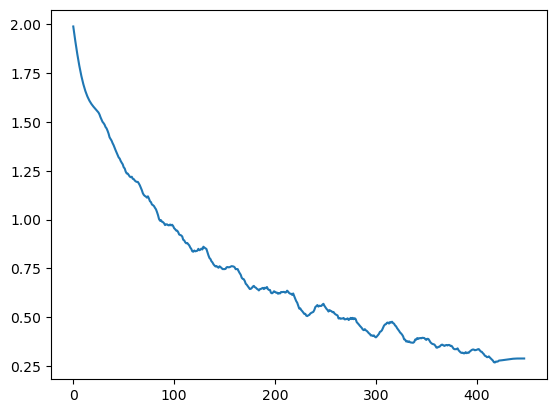

In [12]:
####################################
##  TODO: Do you modifications here
####################################

## load your model
model = CNN().to(device)

## parameters that can be tuned
batch_size = 64
learning_rate = 0.001
num_epochs = 14

## necessary initializations
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

cnn_losses = train_model(model, trainloader, criterion, optimizer, num_epochs=num_epochs)
plt.plot(cnn_losses)
plt.show()

Accuracy on train set: 0.8839


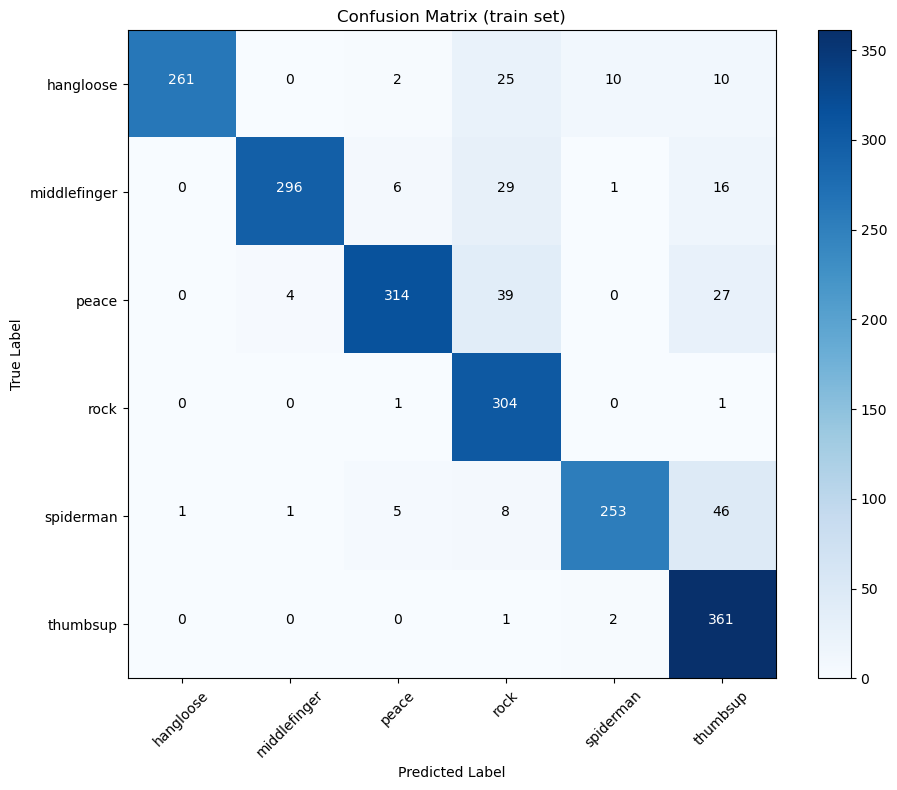

Accuracy on test set: 0.7498


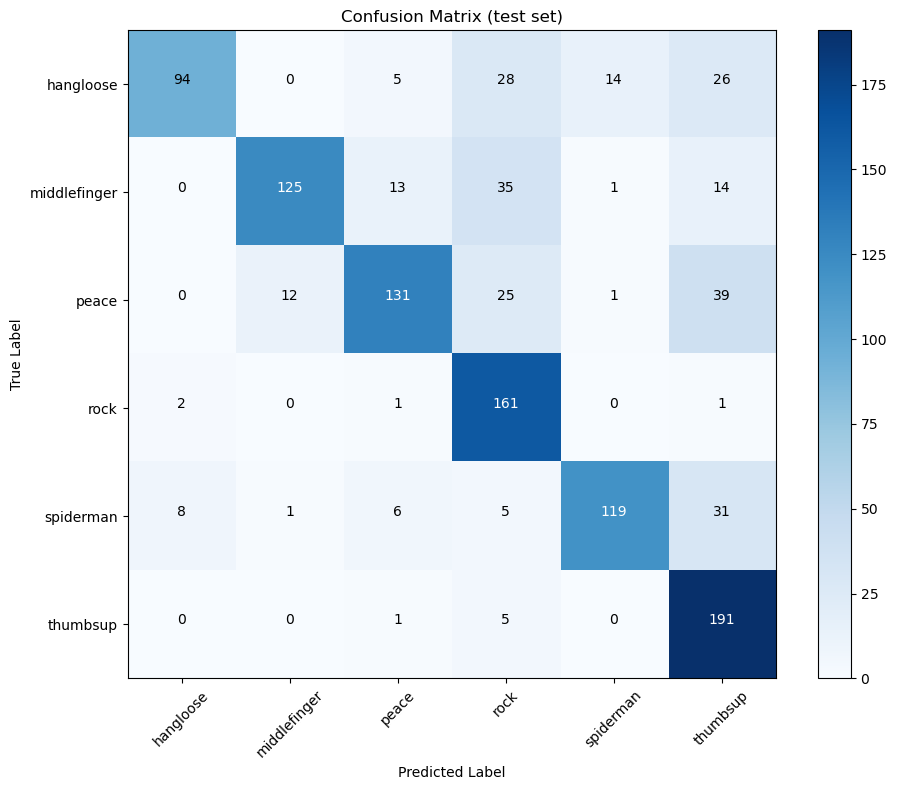

In [13]:
#################################
## This is the cell for checking
## Do NOT edit this cell
#################################
train_acc, train_cm = evaluate_model(model, trainloader, device, "train")
test_acc, test_cm = evaluate_model(model, testloader, device, "test")

Accuracy on train set: 0.9936


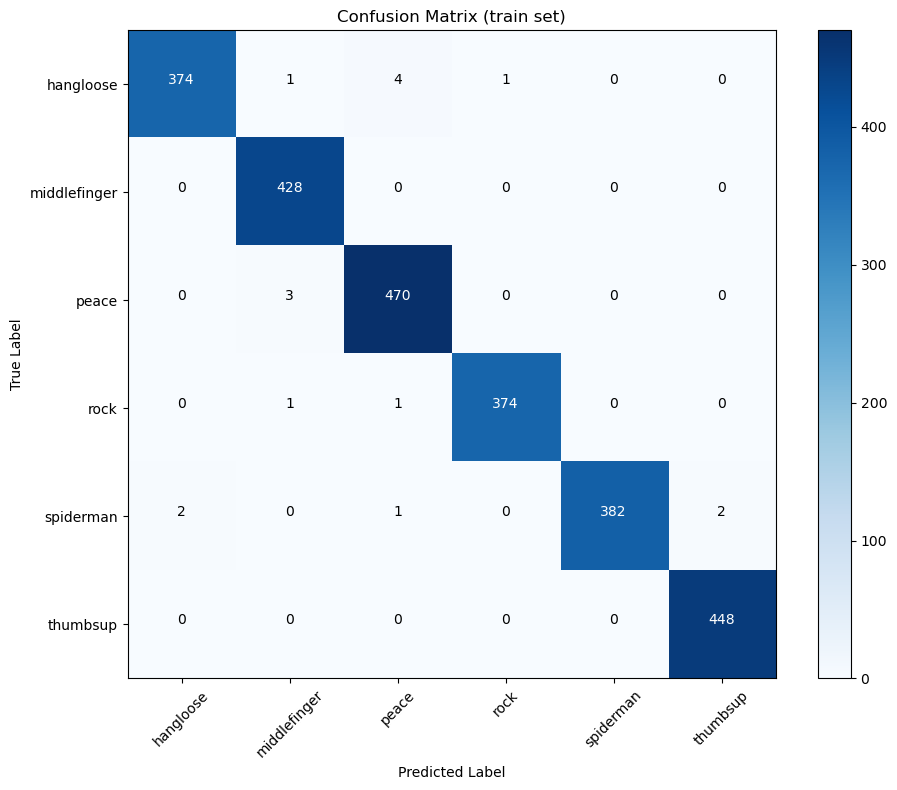

Accuracy on test set: 0.9139


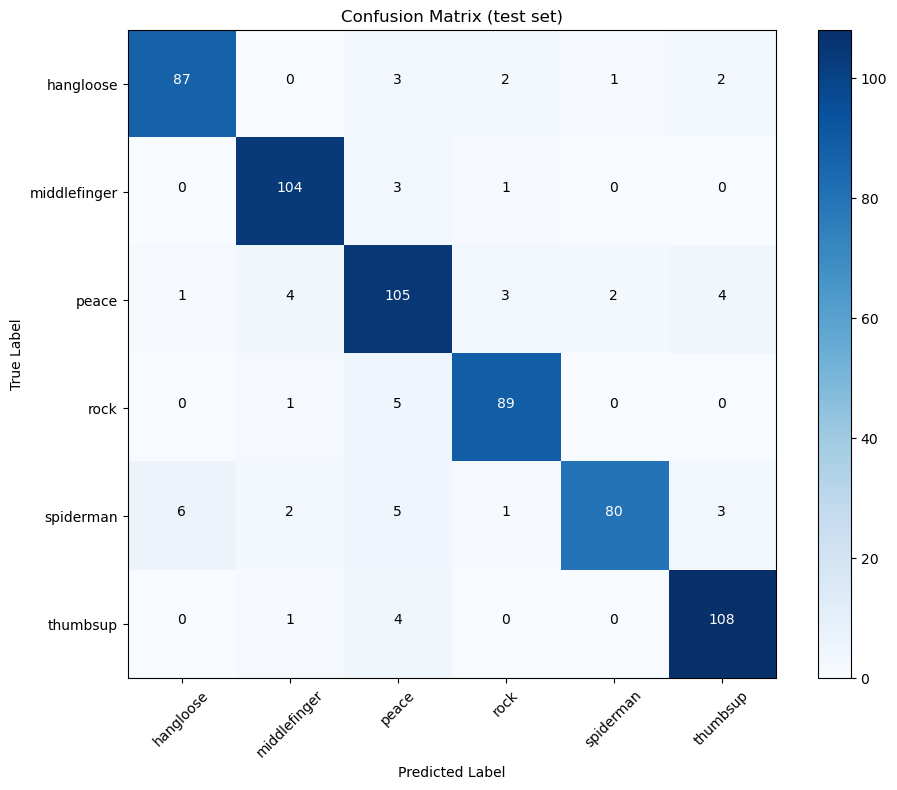

In [34]:
#################################
## This is the cell for checking
## Do NOT edit this cell
#################################
train_acc, train_cm = evaluate_model(model, trainloader, device, "train")
test_acc, test_cm = evaluate_model(model, testloader, device, "test")